### A dataviz demo showcasing graphs for "supports" in the Fire Emblem games.
### In the Fire Emblem (FE) games, characters can sometimes "support" each other. It can be interesting to visualize which characters can support each other at a glance.
### Here, we use a FE wiki page to scrape information regarding these supports, and create graphs from there.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
import time

from matplotlib import pyplot as plt 
from pyvis.network import Network
from selenium import webdriver
from selenium.webdriver.common.by import By

In [2]:
GrandURL = "https://fireemblemwiki.org/wiki/Category:Lists_of_supports"
link_template = "List of supports in Fire Emblem"

In [3]:
# Open a webpage in Firefox, find all links of interest

driver = webdriver.Firefox()
driver.get(GrandURL)

time.sleep(3) # Let the page load
content = driver.find_elements(By.PARTIAL_LINK_TEXT, link_template)

In [4]:
# In example:

content[3].get_attribute('href')

'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'

### The games we wish to create graphs for are not listed in a neat order by release date on the webpage.

### We are also only interested in making graphs for certain games.

### We take a few steps to sort extract the info we need from the games we want.

In [5]:
run = 0
for game in content:
    print(run, game.text)
    run+=1

0 List of supports in Fire Emblem Awakening
1 List of supports in Fire Emblem: The Binding Blade
2 List of supports in Fire Emblem: The Blazing Blade
3 List of supports in Fire Emblem Echoes: Shadows of Valentia
4 List of supports in Fire Emblem Engage
5 List of supports in Fire Emblem Fates
6 List of supports in Fire Emblem: Mystery of the Emblem
7 List of supports in Fire Emblem: Path of Radiance
8 List of supports in Fire Emblem: The Sacred Stones
9 List of supports in Fire Emblem: Shadow Dragon
10 List of supports in Fire Emblem: Thracia 776
11 List of supports in Fire Emblem: Three Houses
12 List of supports in Fire Emblem Warriors
13 List of supports in Fire Emblem Warriors: Three Hopes


In [6]:
GamesOfInterest = {
    "FE6" : 1,
    "FE7" : 2,
    "FE8" : 8,
    "FE9" : 7,
    "FE15" : 3,
    "FE16" : 11,
    "FE17" : 4
}

game_page_links =[]
for v in GamesOfInterest.values():
    game_title = content[v].text
    game_title = game_title.split(link_template)[1]
    game_title = game_title[game_title.find(" ")+1:]
    
    game_link = content[v].get_attribute('href')
    game_page_links.append(
        {"game_title": game_title, "url": game_link}
    )

In [7]:
game_page_links

[{'game_title': 'The Binding Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Binding_Blade'},
 {'game_title': 'The Blazing Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Blazing_Blade'},
 {'game_title': 'The Sacred Stones',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Sacred_Stones'},
 {'game_title': 'Path of Radiance',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Path_of_Radiance'},
 {'game_title': 'Echoes: Shadows of Valentia',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'},
 {'game_title': 'Three Houses',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Three_Houses'},
 {'game_title': 'Engage',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Engage'}]

### We start with FE6: The Binding Blade.
### The lxml optional dependancy is required.

In [8]:
# !pip install lxml

support_table = pd.read_html(game_page_links[0]['url'])
support_table = support_table[1]
support_table = support_table.T
support_table.columns = support_table.iloc[0]
support_table = support_table.drop("Character")
support_table

Character,Roy,Marcus,Alen,Lance,Wolt,Bors,Elen,Dieck,Ward,Lot,...,Garret,Fae,Hugh,Zeiss,Douglas,Niime,Juno,Dayan,Yoder,Karel
1,Marcus,Roy,Roy,Roy,Roy,Astolfo,Chad,Ward,Alen,Lance,...,Lilina,Sue,Chad,Elen,Geese,Raigh,Shanna,Rutger,Saul,Rutger
2,Alen,Alen,Marcus,Marcus,Marcus,Lilina,Lugh,Lot,Dieck,Dieck,...,Geese,Elffin,Lugh,Sin,Larum,Sophia,Zelot,Sue,Dorothy,Noah
3,Lance,Lance,Lance,Alen,Alen,Barthe,Saul,Shanna,Lot,Ward,...,Gonzalez,Sophia,Raigh,Bartre,Elffin,Fae,Trec,Sin,Melady,Fir
4,Wolt,Wolt,Wolt,Wolt,Lance,Ogier,Melady,Clarine,Shanna,Shanna,...,Larum,Igrene,Cath,Melady,Cecilia,Hugh,Noah,Gonzalez,Niime,Bartre
5,Shanna,Lilina,Ward,Lot,Sue,Gwendolyn,Zeiss,Rutger,Echidna,Echidna,...,Cath,Niime,Niime,Karel,Igrene,Yoder,Thea,Yoder,Dayan,Zeiss
6,Sue,--,Thea,Clarine,--,--,--,Klein,--,--,...,--,--,--,--,Perceval,--,--,--,--,--
7,Lilina,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
8,Larum,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
9,Cecilia,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
10,Sophia,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--


### To create nodes for a graph, we neet a source and a target, e.g. (Roy, Marcus).
### Roy has supports with many characters (Marcus, Alen, etc.), while Marcus has fewer.
### All supports are two-way, meaning Roy supports Marcus and Marcus supports Roy, etc.

In [9]:
individual_supports = []
for character in support_table.columns:
    for friend in support_table[character]:
        if friend != "--":
            individual_supports.append({"Source": character, "Target": friend})

individual_supports = pd.DataFrame(individual_supports)

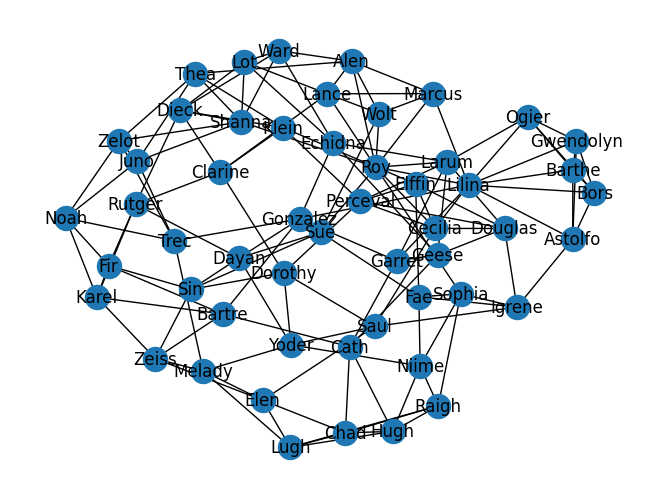

In [10]:
FE6_graph = nx.from_pandas_edgelist(individual_supports,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
pos = nx.kamada_kawai_layout(FE6_graph)
nx.draw(FE6_graph, with_labels=True, pos=pos)
#plt.show()

### The above graph looks gross, so the nice versions will be .png files lokated in this same directory.

In [11]:
# These are som centrality measures to hopefully make the graph look nicer.

node_degree = dict(FE6_graph.degree)
degree_dict = nx.degree_centrality(FE6_graph)
betweenness_dict = nx.betweenness_centrality(FE6_graph)
closeness_dict = nx.closeness_centrality(FE6_graph)

nx.set_node_attributes(FE6_graph, node_degree, 'size')
nx.set_node_attributes(FE6_graph, degree_dict, 'degree_centrality')
nx.set_node_attributes(FE6_graph, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(FE6_graph, closeness_dict, 'closeness_centrality')

communities = community_louvain.best_partition(FE6_graph)
nx.set_node_attributes(FE6_graph, communities, 'group')

In [12]:
net = Network(notebook=True, width="600px", height="600px",cdn_resources='remote')
net.from_nx(FE6_graph)
net.show("FE6.html")

FE6.html


### The above code produces a .html file, which I save as a .png file since VSCode has trouble viewing .html files.

### For the rest of this demo, we have re-factored some of the above code into funcitons to make prducing the graphs for the other games easier.

### We chose to do it this way instead of defining the funcitons above because the jupyter notebook format is easier to follow as a step-by-step document of sorts. This is a redundant way to write code, but the code is easier to read this way, and we prioritize presentation with this demo over funcitonality.

### The remaining games follow.

In [13]:
import FE_helpers as h

In [14]:
game_page_links

[{'game_title': 'The Binding Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Binding_Blade'},
 {'game_title': 'The Blazing Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Blazing_Blade'},
 {'game_title': 'The Sacred Stones',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Sacred_Stones'},
 {'game_title': 'Path of Radiance',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Path_of_Radiance'},
 {'game_title': 'Echoes: Shadows of Valentia',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'},
 {'game_title': 'Three Houses',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Three_Houses'},
 {'game_title': 'Engage',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Engage'}]

In [15]:
# FE7: The Blazing Blade

FE7_supports, FE7_individuals = h.make_support_table(game_page_links[1]['url'])
#FE7_supports

FE7.html


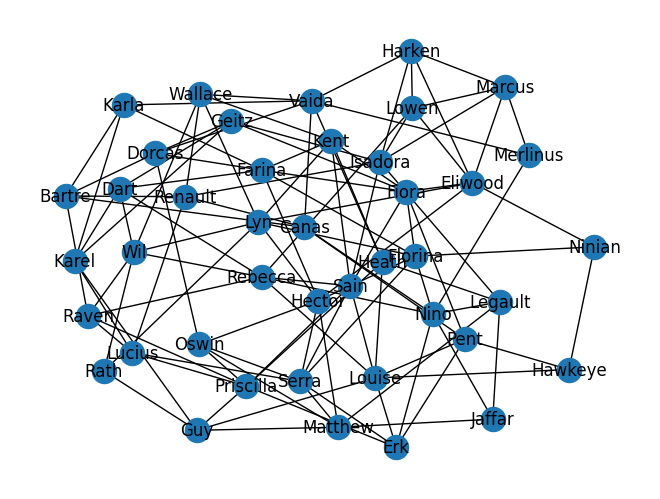

In [16]:
FE7_graph = nx.from_pandas_edgelist(FE7_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE7_graph, "FE7.html")

In [17]:
# FE8: The Sacred Stones

FE8_supports, FE8_individuals = h.make_support_table(game_page_links[2]['url'])
#FE8_supports

FE8.html


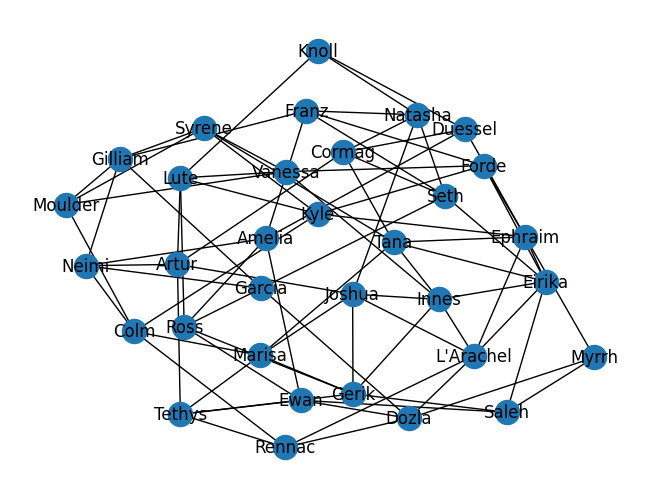

In [18]:
FE8_graph = nx.from_pandas_edgelist(FE8_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE8_graph, "FE8.html")

In [19]:
# FE9: Path of Radiance

FE9_supports, FE9_individuals = h.make_support_table(game_page_links[3]['url'])
#FE9_supports

FE9.html


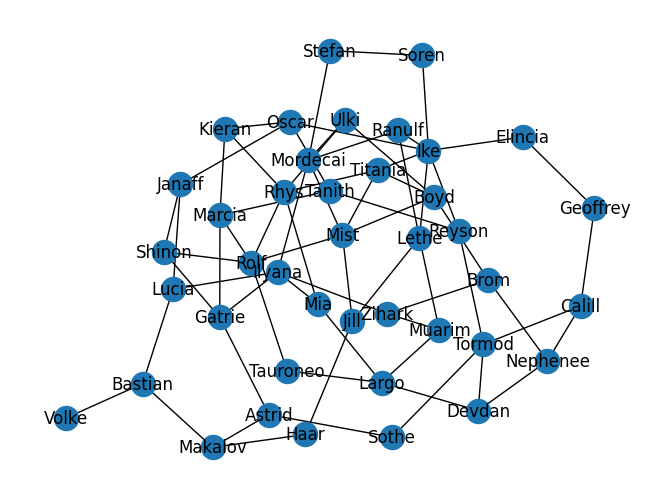

In [20]:
FE9_graph = nx.from_pandas_edgelist(FE9_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE9_graph, "FE9.html")

In [21]:
# FE15: Shadows of Valentia

FE15_supports, FE15_individuals = h.make_support_table(game_page_links[4]['url'])
#FE15_supports

### FE15 actually needs more work. The wiki webpage includes more supports in a separate table, so the above dataframe is missing data. The code here is mostly the same as before.

### Additionally, FE15 has another mechanic called "bonds," which are almost the same as supports. Celica has a bond with Alm but not a support, and so we create graphs for supports and bonds.

In [22]:
temp = pd.read_html(game_page_links[4]['url'])
supp2, bonds = temp[2], temp[3]
supp2, bonds = supp2.T, bonds.T
supp2.columns, bonds.columns = supp2.iloc[0], bonds.iloc[0]
supp2, bonds = supp2.drop("Character"), bonds.drop("Character")

FE15_supports = FE15_supports.T.merge(supp2.T, on='Character', how='outer')
FE15_supports = FE15_supports.T

In [23]:
FE15_individuals = []
for character in FE15_supports.columns:
    for friend in FE15_supports[character]:
        if friend != "--":
            FE15_individuals.append({"Source": character, "Target": friend})
FE15_individuals = pd.DataFrame(FE15_individuals).dropna()

In [24]:
bonds_nodes =[]
for character in bonds:
    for friend in bonds[character]:
        if friend != "--":
            bonds_nodes.append({"Source": character, "Target": friend})
FE15_bonds = pd.DataFrame(bonds_nodes)

In [25]:
FE15_supp_graph = nx.from_pandas_edgelist(FE15_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
FE15_bonds_graph = nx.from_pandas_edgelist(FE15_bonds,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())

FE15.html


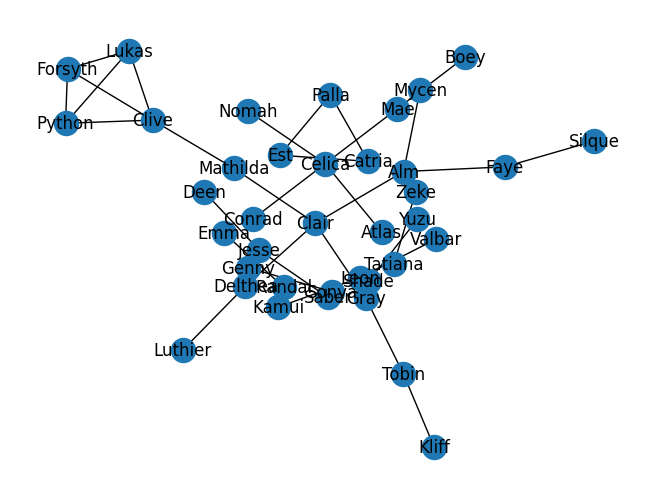

In [26]:
h.grand_graph_draw(FE15_supp_graph, "FE15.html")

FE15_bonds.html


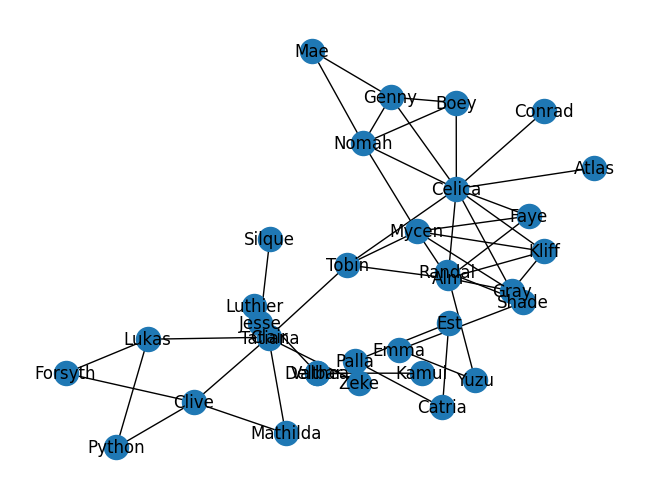

In [27]:
h.grand_graph_draw(FE15_bonds_graph, "FE15_bonds.html")

### FE16 needs a little more cleaning as well.

### Byleth (M) is identical to Byleth (F) for our purposes. Additionally, Byleth supports every single character (and vice-versa, every character supports Byleth). As such, the final graph will be extremely messy and dense around Byleth. We will just remove both Byleth (M) and Byleth (F) from consideration altogether, since these characters are redundant and the resulting graph will be much cleaner.

In [28]:
# FE16: Three Houses

FE16_supports, FE16_individuals = h.make_support_table(game_page_links[5]['url'])
FE16_supports = FE16_supports.T.dropna().T
FE16_supports = FE16_supports.drop("Byleth (M)", axis=1)
FE16_supports = FE16_supports.drop("Byleth (F)", axis=1)


In [29]:
FE16_supports

Character,Edelgard,Dimitri,Dimitri,Claude,Claude,Hubert,Ferdinand,Ferdinand,Linhardt,Linhardt,...,Catherine,Shamir,Cyril,Rhea,Sothis,Jeritza,Yuri,Balthus,Constance,Hapi
1,Byleth (M),Byleth (M),Hapi,Byleth (M),Balthus,Byleth (M),Byleth (M),Constance,Byleth (M),Hapi,...,Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M)
2,Byleth (F),Byleth (F),--,Byleth (F),--,Byleth (F),Byleth (F),--,Byleth (F),--,...,Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F)
3,Hubert,Dedue,--,Petra,--,Edelgard,Edelgard,--,Edelgard,--,...,Dimitri,Claude,Claude,--,--,Bernadetta,Bernadetta,Claude,Edelgard,Dimitri
4,Ferdinand,Felix,--,Annette,--,Ferdinand,Hubert,--,Hubert,--,...,Linhardt,Hubert,Petra,--,--,Mercedes,Dorothea,Lysithea,Ferdinand,Linhardt
5,Linhardt,Ashe,--,Ingrid,--,Linhardt,Linhardt,--,Ferdinand,--,...,Caspar,Caspar,Ashe,--,--,Constance,Ingrid,Hilda,Mercedes,Ashe
6,Caspar,Sylvain,--,Lorenz,--,Caspar,Caspar,--,Caspar,--,...,Ashe,Petra,Mercedes,--,--,--,Balthus,Yuri,Jeritza,Yuri
7,Bernadetta,Mercedes,--,Raphael,--,Bernadetta,Bernadetta,--,Bernadetta,--,...,Ingrid,Dedue,Ignatz,--,--,--,Constance,Constance,Yuri,Balthus
8,Dorothea,Annette,--,Ignatz,--,Dorothea,Dorothea,--,Dorothea,--,...,Lorenz,Raphael,Lysithea,--,--,--,Hapi,Hapi,Balthus,Constance
9,Petra,Ingrid,--,Lysithea,--,Petra,Petra,--,Petra,--,...,Lysithea,Ignatz,Hilda,--,--,--,--,--,Hapi,--
10,Lysithea,Raphael,--,Marianne,--,Hanneman,Mercedes,--,Annette,--,...,Leonie,Leonie,Seteth,--,--,--,--,--,--,--


In [30]:
# This code essentially 'merges' the columns which have identical names:
# e.g. There are two columns for "Dimitri" above due to html formatting on the website.

FE16_supports = (FE16_supports.set_axis(
    pd.MultiIndex.from_arrays(
        [FE16_supports.columns, FE16_supports.groupby(level=0, axis=1).cumcount()]
    ), axis=1
).stack(level=1)
.sort_index(level=1)
.droplevel(1)
.drop_duplicates(subset=FE16_supports.columns[FE16_supports.columns.duplicated()])
)

C:\Users\Jim\AppData\Local\Temp\ipykernel_9468\2324366659.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  [FE16_supports.columns, FE16_supports.groupby(level=0, axis=1).cumcount()]
C:\Users\Jim\AppData\Local\Temp\ipykernel_9468\2324366659.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ).stack(level=1)


In [31]:
FE16_supports

Character,Edelgard,Dimitri,Claude,Hubert,Ferdinand,Linhardt,Caspar,Bernadetta,Dorothea,Petra,...,Catherine,Shamir,Cyril,Rhea,Sothis,Jeritza,Yuri,Balthus,Constance,Hapi
1,Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),...,Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M),Byleth (M)
10,Lysithea,Raphael,Marianne,Hanneman,Mercedes,Annette,Ashe,Felix,Felix,Dorothea,...,Leonie,Leonie,Seteth,--,--,--,--,--,--,--
11,Hanneman,Marianne,Hilda,Shamir,Lorenz,Lysithea,Annette,Sylvain,Sylvain,Ashe,...,Seteth,Alois,Manuela,--,--,--,--,--,--,--
12,Manuela,Flayn,Leonie,--,Marianne,Marianne,Raphael,Ingrid,Ingrid,Ignatz,...,Gilbert,Catherine,Shamir,--,--,--,--,--,--,--
13,Constance,Gilbert,Flayn,--,Hilda,Flayn,Hilda,Raphael,Lorenz,Alois,...,Alois,Cyril,--,--,--,--,--,--,--,--
14,--,Alois,Shamir,--,Flayn,Hanneman,Catherine,Leonie,Hanneman,Shamir,...,Shamir,--,--,--,--,--,--,--,--,--
15,--,Catherine,Cyril,--,Manuela,Catherine,Shamir,Seteth,Manuela,Cyril,...,--,--,--,--,--,--,--,--,--,--
2,Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),...,Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F),Byleth (F)
3,Hubert,Dedue,Petra,Edelgard,Edelgard,Edelgard,Edelgard,Edelgard,Edelgard,Edelgard,...,Dimitri,Claude,Claude,--,--,Bernadetta,Bernadetta,Claude,Edelgard,Dimitri
4,Ferdinand,Felix,Annette,Ferdinand,Hubert,Hubert,Hubert,Hubert,Hubert,Claude,...,Linhardt,Hubert,Petra,--,--,Mercedes,Dorothea,Lysithea,Ferdinand,Linhardt


In [32]:
FE16_individuals = []
for character in FE16_supports.columns:
    for friend in FE16_supports[character]:
        if friend != "--" and type(friend) == str:
            FE16_individuals.append({"Source": character, "Target": friend})

FE16_individuals = pd.DataFrame(FE16_individuals)
FE16_individuals = FE16_individuals[FE16_individuals.Target != "Byleth (M)"]
FE16_individuals = FE16_individuals[FE16_individuals.Target != "Byleth (F)"]

FE16.html


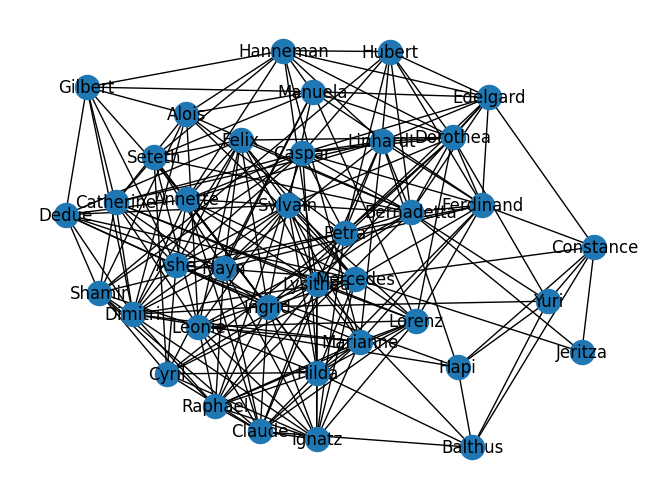

In [33]:
FE16_graph = nx.from_pandas_edgelist(FE16_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE16_graph, "FE16.html", size=800)